In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import dateparser
import pandas as pd
import json
import nltk
import numpy as np
import string
import re
import csv
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from functions import *
import dateparser
from fuzzysearch import find_near_matches
from ccfMitchell import ccf

In [2]:
df_data = load_data_tagtog(['../tagtog/output']).fillna('')
df_data = df_data.loc[df_data['is_flood'].astype(bool)]

In [3]:
override=False
if not override and os.path.exists('timeseries_data/all_isFlood.json'):
    df_data = pd.read_json('timeseries_data/all_isFlood.json')
else:
    df_data = add_prev_true_data(df_data)
    df_data = add_newspapers(df_data)
    df_data = add_datePublished(df_data)
    df_data = add_location(df_data)
df_data.head()

,doc_id,filename,is_flood,is_bangladesh,flood_related,flood_climatechange,newspaper,flood_type,text,dates,anomaly,districts,divisions,datePublished,connect_filename
0,ec583817-3c60-41ee-b856-65f0d9bd7772,dailySun_data_ec583817-3c60-41ee-b856-65f0d9bd...,True,,,,dailySun,,Date Published:2017-08-31 06:03:11+00:00 tuesd...,[],,[narail],[khulna],2017-08-31 06:03:11+00:00,
1,f4806621-b874-4f20-97fb-f7c1fa94f6bc,theDailyStar_data_f4806621-b874-4f20-97fb-f7c1...,True,True,True,False,theDailyStar,flash,Date Published:2016-05-05 00:00:00 Flash flood...,[],2016-05-01,"[habiganj, sylhet, sunamganj]","[sylhet, sylhet, sylhet, sylhet]",2016-05-05 00:00:00,
2,259d503d-f6b1-44b6-a866-8eff03799a07,prothomalo_data_259d503d-f6b1-44b6-a866-8eff03...,True,,,,prothomalo,,Date Published:None Flood situation worsened f...,[],,"[sirajganj, sherpur, kurigram, sylhet, lalmoni...","[rajshahi, dhaka, rangpur, sylhet, rangpur, ra...",2019-07-17T03:35:13Z,
3,efc6373e-fce0-40da-9db9-d645a8f3b37f,dailySun_data_efc6373e-fce0-40da-9db9-d645a8f3...,True,,,,dailySun,,Date Published:2018-08-22 04:03:52+00:00 tuesd...,[],,[],[],2018-08-22 04:03:52+00:00,
4,f3e3bc49-143b-41fb-a0ed-1a1c7e8b86e0,dailySun_data_f3e3bc49-143b-41fb-a0ed-1a1c7e8b...,True,,,,dailySun,,"Date Published:2019-10-13 00:00:00 tuesday, 21...",[],,[],[],2019-10-13 00:00:00,


In [4]:
def complete_day_loc(list1, year_range = [2015, None], aggType=None, onlyUnique=False):
    dict1_year_months_day = {i[0]:i[1] for i in list1}
    all_years = set([int(i.split('-')[0]) for i in dict1_year_months_day.keys()])
    
    min_year, max_year = min(all_years), max(all_years)
    min_range = year_range[0] if year_range[0] is not None else min_year
    max_range = year_range[1] if year_range[1] is not None else max_year
    all_years = range(min_range, max_range+1)
    
    d1_year_month_day = []
    for i in all_years:
        count = 0
        monthRange = 13
        if i == 2020: monthRange = 10
        for months in range(1,monthRange):
            day_range = 31 if months in [1,3,5,7,8,10,12] else 30
            if months==2:
                if isLeap(i): day_range = 29
                else: day_range = 28
            toAdd = 0
            toAddSet = set()
            for day in range(1, day_range+1):
                key = str(i)+'-'+str(months)+'-'+str(day)
                val = dict1_year_months_day.get(key, set())
                if onlyUnique:
                    toAddSet = toAddSet.union(val)
                    toAdd = len(toAddSet)
                else: toAdd += len(val)
                if (aggType is None) or (aggType=='week' and day%7==0) \
                or (aggType=='fortnight' and day%15==0) or (day == day_range and aggType!='month'):
                    d1_year_month_day.append((key,toAdd))
                    toAdd = 0
                count += 1
            if (aggType=='month'):
                key = str(i)+'-'+str(months)
                if onlyUnique:
                    toAdd = len(toAddSet)
                d1_year_month_day.append((key,toAdd))

    l1 = sorted(d1_year_month_day, key=lambda x:tuple(map(int, x[0].split('-'))))
    return l1

## Flood articles per month, per district (Eugene)

In [5]:
def get_district_articles_distribution(df_data, top=0):
    div_to_dist, dist_to_div = get_dist_divD()
    districts = list(dist_to_div)
    districts_df, districts_n, dist_top = {}, {}, []
    for d in districts:
        temp_df = get_district_articles(df_data, d)
        dates = parse_all_dates(temp_df['datePublished'])
        dist_top.append((d,len(dates)))
        years, months = [], []
        for d3 in dates:
            if d3:
                years.append(d3['year'])
                months.append(d3['month'])
            else:
                years.append(0)
                months.append(0)
        temp_df['years'], temp_df['months'] = years, months
        temp_df['location'] = [d for _ in range(len(temp_df))]
        districts_df[d] = temp_df[['doc_id', 'filename', 'years', 'months', 'location', 'newspaper']] \
                            .sort_values(by=['years', 'months'])
        yearPublished_count_list, yearPublished_month_count_list, _ = date_counts(dates)
        yearPublished_month_count_list = get_month_range(yearPublished_month_count_list, [2017, 2020])
        districts_n[d] = {
            'yearPublished': yearPublished_count_list,
            'year_monthPublished': yearPublished_month_count_list
        }
    if top:
        dist_top.sort(key=lambda x:x[1], reverse=True)
        new_districts_df, new_districts_n = {}, {}
        for dist, distn in dist_top[:top]:
            new_districts_df[dist] = districts_df[dist]
            new_districts_n[dist] = districts_n[dist]
        return new_districts_df, new_districts_n
    return districts_df, districts_n
districts_df, districts_n = get_district_articles_distribution(df_data, top=10)

NameError: name 'get_district_articles' is not defined

In [6]:
def get_s_val(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    return 20*2.5**(currVal//diff) if currVal//diff else 0

def get_colors(currVal, minVal, maxVal, div=4):
    colors = ['#FFFF00','#0000FF','#008000','#FF0000','#FFA500']
    diff = (maxVal-minVal)//div
    return colors[currVal//diff]

def get_labels(currVal, minVal, maxVal, div=4):
    diff = (maxVal-minVal)//div
    if currVal==0: return ''
    for i in range(div):
        if i==div-1: return '>{}'.format((diff*i)+1)
        if (diff*i)+1 <= currVal <= diff*(i+1):
            return '{}-{}'.format((diff*i)+1,diff*(i+1))
    return ''
    
def plot_district_articles_distribution(districts_n, title=None, xlabel=None, ylabel=None, 
                                        xticks_rotate=True, skip=True):
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    div = 4
    fig, ax = plt.subplots(figsize=(15,7))
    xvals = [i[0] for i in districts_n['sylhet']['year_monthPublished']]
    yvals_name = list(districts_n)
    yvals = [[districts_n[dname]['year_monthPublished'][i][1] for dname in yvals_name] for i,ym in enumerate(xvals)]
    maxVal, minVal = -float('inf'), float('inf')
    for y in yvals:
        for count in y:
            maxVal, minVal = max(maxVal, count), min(minVal, count)
    for i in range(len(xvals)):
        ax.scatter([xvals[i]]*len(yvals[i]), range(len(yvals[i])), 
                   s=[get_s_val(i,minVal,maxVal) for i in yvals[i]], 
                   c=[get_colors(i,minVal,maxVal) for i in yvals[i]])
    legend_elements = [Line2D([0], [0], linewidth=0, marker='o', 
                              color=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              label=get_labels(((maxVal-minVal)//div)*i, minVal, maxVal),
                              markerfacecolor=get_colors(((maxVal-minVal)//div)*i, minVal, maxVal), 
                              markersize=i**2+5)
                       for i in range(div+1) if i!=0
                   ]
    
    plt.legend(handles=legend_elements, fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
    if not title: title = 'District vs Flood Article Year-Month published. For top 10 districts with most articles.\n \
        Number of Flood Articles in the year-month denoted by different sized circles'
    if not xlabel: xlabel = 'Article Year-Month Published'
    if not ylabel: ylabel = 'District'
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(range(len(yvals_name)), labels=yvals_name)
    if xticks_rotate: plt.xticks(rotation='vertical')
    if skip:
        ax = plt.gca()
        temp = ax.xaxis.get_ticklabels()
        temp = list(set(temp) - set(temp[::3]))
        for label in temp:
            label.set_visible(False)
    plt.show()
plot_district_articles_distribution(districts_n)

NameError: name 'districts_n' is not defined

## Location denormalization

In [5]:
dates_all = query_dataframe(df_data,{'is_flood':True})['datePublished']
dates = parse_all_dates(dates_all)
df_data['datesP'] = dates

('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', '2031-12-30 00:00:00') 2031-12-30 00:00:00
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Present', 'None') None
('No Date Pre

In [6]:
datesLocation = defaultdict(set)
for row in df_data.iterrows():
    entry = row[1]
    dates = entry['datesP']
    if not dates:
#         print(entry)
        continue
    year, month, day = dates['year'], dates['month'], dates['day']
    if not year or not month or not day:
#         print(entry)
        continue
    for loc in entry['districts']: datesLocation['{}-{}-{}'.format(year, month, day)].add(loc)

In [55]:
articleDates = json.load(open('timeseries_data/yearPublished_day.json'))
articleDatesSylhet = json.load(open('timeseries_data/yearPublished_day_sylhet.json'))
articleDatesRajshahi = json.load(open('timeseries_data/yearPublished_day_rajshahi.json'))
articleDatesDhaka = json.load(open('timeseries_data/yearPublished_day_dhaka.json'))

### Daily Locations

In [9]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2019, 2019])
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2019,2019])

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'flood articles per day', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'Daily number of unique locations', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Daily - Number of Unique locations vs Date', 'Date', True, skip=30)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Daily - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=30)

In [10]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None])
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,None])

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True, 
#     title='Daily - Number of Unique locations', lag_max=50)

### Weekly Aggregate locations

In [11]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], aggType='week')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,None], aggType='week')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per week', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (Weekly Aggregate)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Weekly Aggregate of number of unique locations and total flood articles vs Date', 'Date', 
#     True, skip=5)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Aggregate Weekly - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=5)

In [12]:
# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Weekly Aggregate of number of unique locations', lag_max=150)

### Fortnightly Aggregate locations

In [9]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], aggType='fortnight')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,None], aggType='fortnight')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per fortnight', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (Fortnight Aggregate)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Fortnight Aggregate of number of unique locations and total flood articles vs Date', 'Date', 
#     True, skip=5)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Aggregate Fortnightly - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=5)

In [10]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))        
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], aggType='fortnight')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='fortnight')

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Fortnight Aggregate of number of unique locations (1990s-)', lag_max=100)


### Monthly Aggregate location

In [11]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], aggType='month')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per month', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (Monthly Aggregate)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Monthly Aggregate of number of unique locations and total flood articles vs Date', 'Date', 
#     True, skip=12)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Aggregate Monthly - Number of Unique locations vs Date', 'Date', '# Locations', True)

In [12]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], aggType='month')
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Monthly Aggregate of number of unique locations (1990s-)', lag_max=50)

## Unique location

In [16]:
def uniqueLoc(datesLocation, articleDates, aggType='fortnight', skip=5, year_range=[2015, None]):
    datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
    datesLocationList2 = complete_day_loc(datesLocationList, year_range=year_range, 
                                          aggType=aggType, onlyUnique=True)
    articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=year_range, 
                                    aggType=aggType)

    plot_2timeseries(
                {'count_list': articleDatesList, 'label':'total flood articles per',
                 'color': 'b', 'ylabel': '# flood articles'},
                {'count_list': datesLocationList2, 'label':'# unique locations (fortnight)', 
                 'color':'r', 'ylabel':'# Locations'},
                'Number of unique locations per fortnight and total flood articles vs Date', 'Date', 
        True, skip=5)
    

### Weekly Unique location

In [17]:
# datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
#                           key=lambda x:(tuple(map(int, x[0].split('-')))))
# datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2015, None], 
#                                       aggType='week', onlyUnique=True)
# articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2015,None], aggType='week')

# plot_2timeseries(
#             {'count_list': articleDatesList, 'label':'total flood articles per week', 
#              'color': 'b', 'ylabel': '# flood articles'},
#             {'count_list': datesLocationList2, 'label':'# unique locations (week)', 
#              'color':'r', 'ylabel':'# Locations'},
#             'Number of unique locations per week and total flood articles vs Date', 'Date', 
#     True, skip=5)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Unique Weekly - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=30)

In [18]:
# ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
#     title='Number of unique locations per week')

### Fortnightly unique location

<Figure size 1080x504 with 0 Axes>

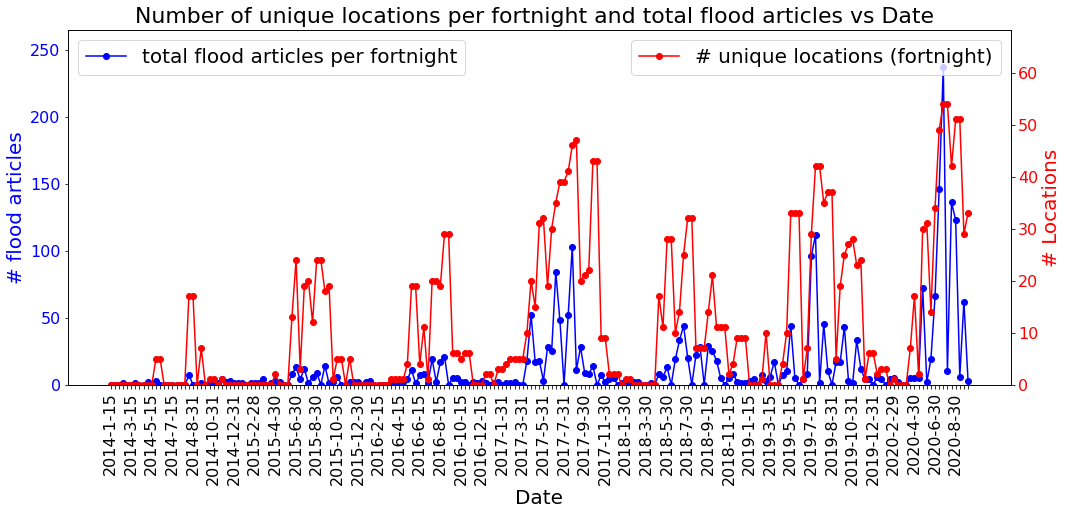

In [19]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2014, None], 
                                      aggType='fortnight', onlyUnique=True)
articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,None], aggType='fortnight')

plot_2timeseries(
            {'count_list': articleDatesList, 'label':'total flood articles per fortnight', 
             'color': 'b', 'ylabel': '# flood articles'},
            {'count_list': datesLocationList2, 'label':'# unique locations (fortnight)', 
             'color':'r', 'ylabel':'# Locations'},
            'Number of unique locations per fortnight and total flood articles vs Date', 'Date', 
    True, skip=5)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Unique Aggregate Fortnightly - Number of Unique locations vs Date', 'Date', '# Locations', True, skip=5)

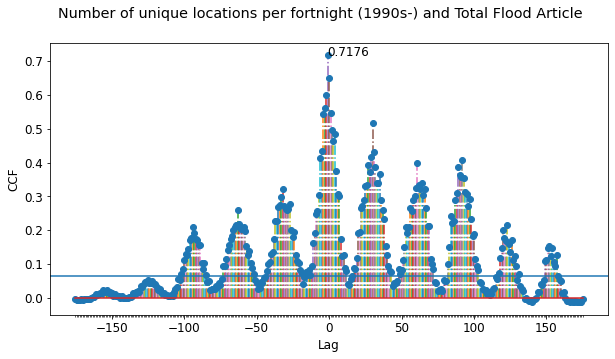

In [22]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], 
                                      aggType='fortnight', onlyUnique=True)
articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='fortnight')

ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
    title='Number of unique locations per fortnight (1990s-) and Total Flood Article', lag_max=175)


### Monthly unique location

<Figure size 1080x504 with 0 Axes>

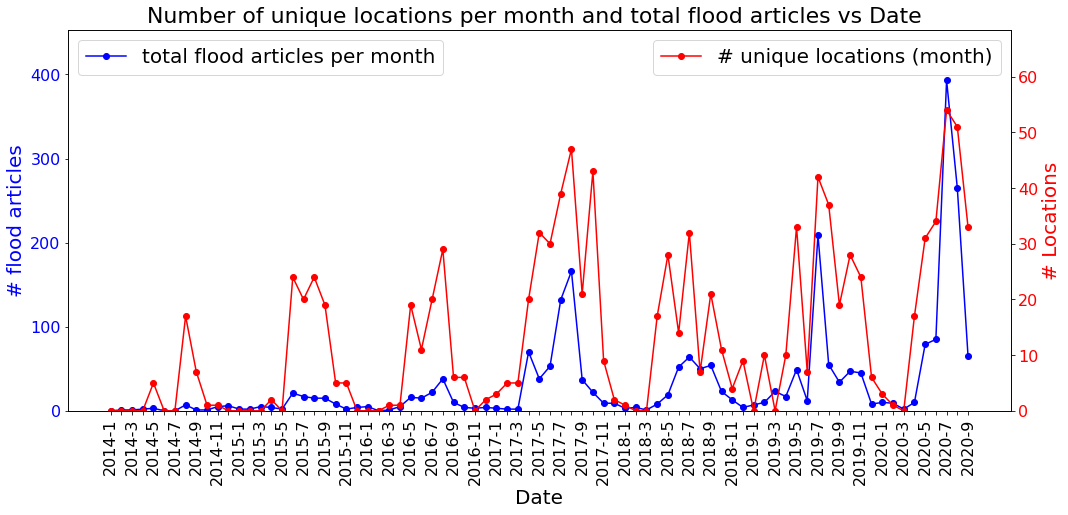

In [20]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2014, None], 
                                      aggType='month', onlyUnique=True)
articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,None], aggType='month')

plot_2timeseries(
            {'count_list': articleDatesList, 'label':'total flood articles per month', 
             'color': 'b', 'ylabel': '# flood articles'},
            {'count_list': datesLocationList2, 'label':'# unique locations (month)', 
             'color':'r', 'ylabel':'# Locations'},
            'Number of unique locations per month and total flood articles vs Date', 'Date', 
    True, skip=2)

# plot_timeseries([
#         {'count_list': datesLocationList2, 'label':'Number of Unique locations'},
#     ], 'Unique Aggregate Monthly - Number of Unique locations vs Date', 'Date', '# Locations', True)

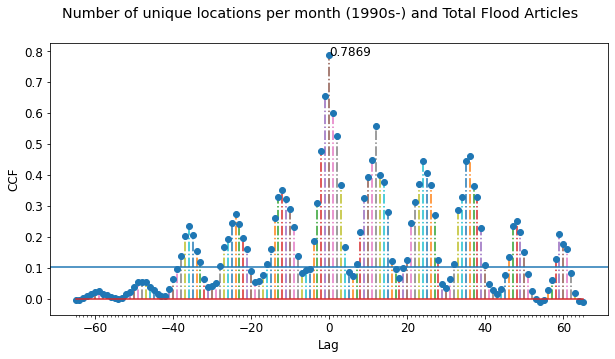

In [18]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
datesLocationList2 = complete_day_loc(datesLocationList, year_range=[1990, None], 
                                      aggType='month', onlyUnique=True)
articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[1990,None], aggType='month')

ccf(articleDatesList, datesLocationList2, tupList=True, plot=True,
    title='Number of unique locations per month (1990s-) and Total Flood Articles', lag_max=65)

In [ ]:
datesLocationList = sorted([(k,v) for k,v in datesLocation.items()],
                          key=lambda x:(tuple(map(int, x[0].split('-')))))
datesLocationList2 = complete_day_loc(datesLocationList, year_range=[2014, None], 
                                      aggType='month', onlyUnique=True)
articleDatesList = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2014,None], aggType='month')

plot_2timeseries(
            {'count_list': articleDatesList, 'label':'total flood articles per month', 
             'color': 'b', 'ylabel': '# flood articles'},
            {'count_list': datesLocationList2, 'label':'# unique locations (month)', 
             'color':'r', 'ylabel':'# Locations'},
            'Number of unique locations per month and total flood articles vs Date', 'Date', 
    True, skip=2)

## Common Term Denormalization

In [36]:
siteCounts = json.load(open('siteCounts.json'))
dateCounts = defaultdict(int)
for paper_name, paperEntry in siteCounts.items():
    for entry in paperEntry:
        month, day, year = entry['date_range'].split('/')[:]
        diffFormatDate = '{}-{}-{}'.format(year, month, day)
        dateCounts[diffFormatDate]+=entry['site_count']

In [38]:
paperDist = {k:defaultdict(int) for k in range(2014, 2021)}
for paper_name, paperEntry in siteCounts.items():
    for entry in paperEntry:
        for date in paperDist:
            if str(date) in entry['date_range']: paperDist[date][paper_name] += entry['site_count']
paperDist

{2014: defaultdict(int, {}),
 2015: defaultdict(int, {}),
 2016: defaultdict(int, {}),
 2017: defaultdict(int,
             {'theDailyStar': 6023,
              'bdnews': 9074,
              'dailySun': 5743,
              'dhakaTribune': 2643,
              'newAge': 2631,
              'prothomalo': 186,
              'theIndependent': 4392}),
 2018: defaultdict(int,
             {'theDailyStar': 8487,
              'bdnews': 9847,
              'dailySun': 8100,
              'dhakaTribune': 5279,
              'newAge': 3151,
              'prothomalo': 370,
              'theIndependent': 3230}),
 2019: defaultdict(int,
             {'theDailyStar': 9164,
              'bdnews': 9247,
              'dailyObserver': 611,
              'dailySun': 9241,
              'dhakaTribune': 8358,
              'newAge': 4074,
              'prothomalo': 560,
              'theIndependent': 1895}),
 2020: defaultdict(int,
             {'theDailyStar': 35784,
              'bdnews': 34068,
  

In [39]:
sum([v for k,v in dateCounts.items() if '2014' in k]), \
sum([v for k,v in dateCounts.items() if '2015' in k]), \
sum([v for k,v in dateCounts.items() if '2016' in k]), \
sum([v for k,v in dateCounts.items() if '2017' in k]), \
sum([v for k,v in dateCounts.items() if '2018' in k]), \
sum([v for k,v in dateCounts.items() if '2019' in k]), \
sum([v for k,v in dateCounts.items() if '2020' in k])

(0, 0, 0, 30692, 38464, 43150, 122708)

#### month

No handles with labels found to put in legend.


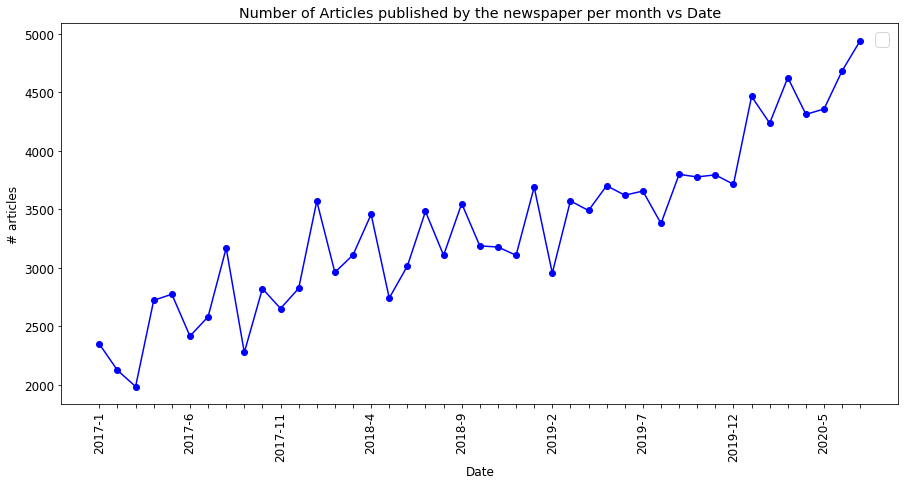

In [43]:
aggNorm = complete_day([(k,v) for k,v in dateCounts.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates={2020:[8,9]})
plot_timeseries([
        {'count_list': aggNorm, 'label':''},
    ], 'Number of Articles published by the newspaper per month vs Date', 'Date', '# articles', True, skip=5)

### Normalized

#### Fortnightly, norm = 'monthly'

<Figure size 1080x504 with 0 Axes>

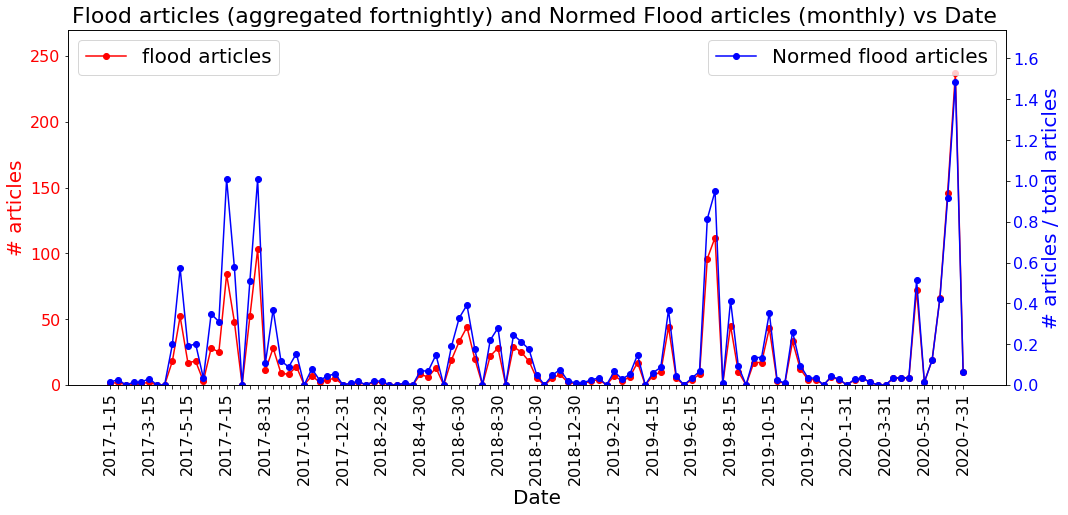

In [45]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,None], 
                      aggType='fortnight', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,None], 
                      aggType='fortnight', normDict=dateCounts, normAgg='month', ignoreDates={2020:[8,9]})

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total articles'},
            'Flood articles (aggregated fortnightly) and Normed Flood articles (monthly) vs Date', 'Date', True, skip=5)


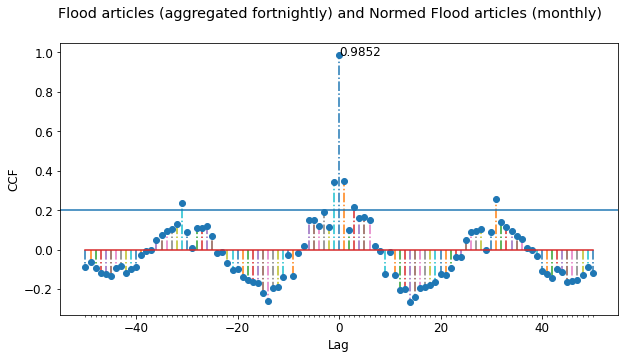

In [46]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2019], 
                      aggType='fortnight', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2019], 
                      aggType='fortnight', normDict=dateCounts, normAgg='month', ignoreDates={2020:[8,9]})

ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated fortnightly) and Normed Flood articles (monthly)', lag_max=50)

#### Fortnightly, norm='yearly'

<Figure size 1080x504 with 0 Axes>

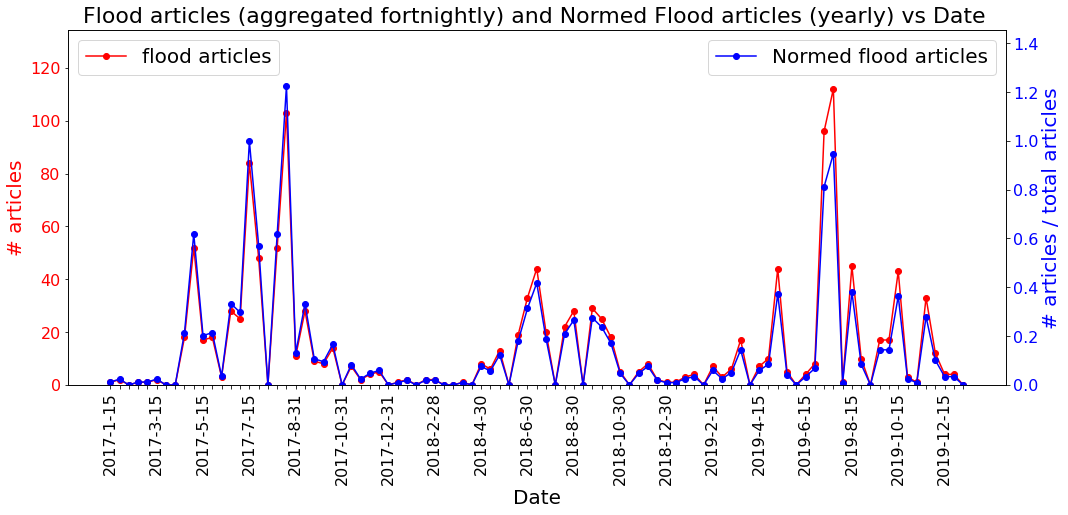

In [47]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2019], 
                      aggType='fortnight', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2019], 
                      aggType='fortnight', normDict=dateCounts, normAgg='year', ignoreDates={2020:[8,9]})

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total articles'},
            'Flood articles (aggregated fortnightly) and Normed Flood articles (yearly) vs Date', 'Date', True, skip=5)


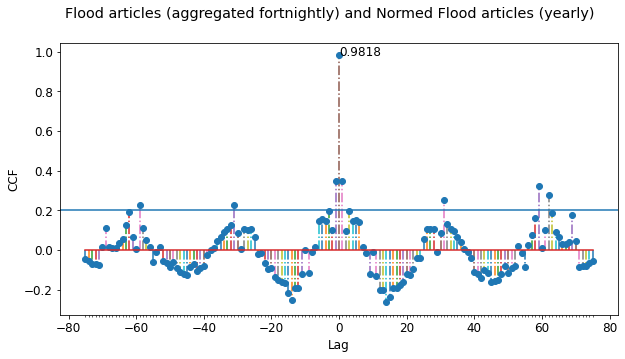

In [51]:
ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated fortnightly) and Normed Flood articles (yearly)', lag_max=75)

#### Monthly, norm='monthly'

<Figure size 1080x504 with 0 Axes>

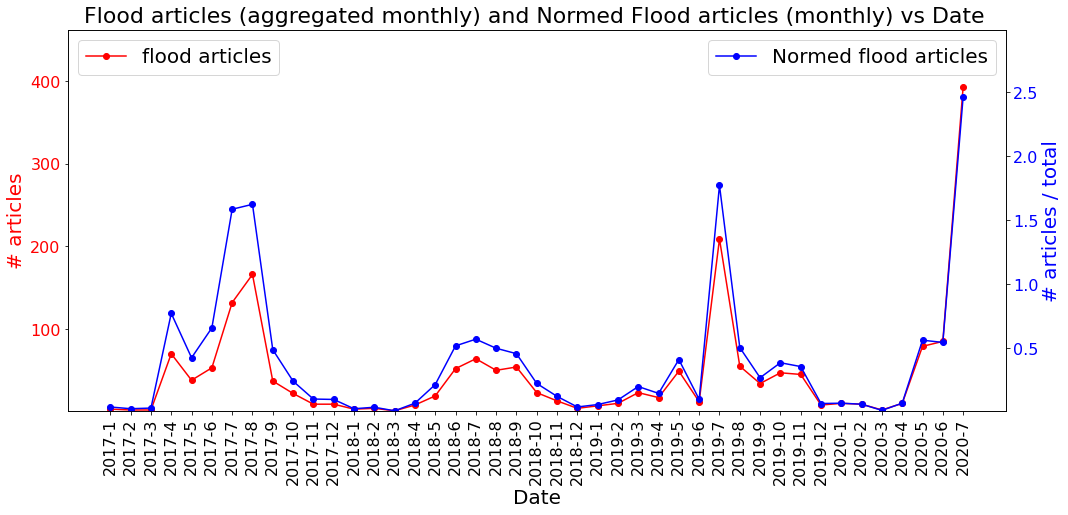

In [52]:
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates={2020:[8,9]})
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='month', ignoreDates={2020:[8,9]})

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Flood articles (aggregated monthly) and Normed Flood articles (monthly) vs Date', 'Date', True)


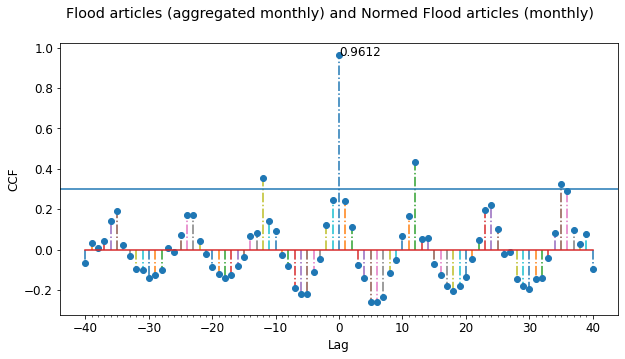

In [53]:
ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated monthly) and Normed Flood articles (monthly)', lag_max=40)

#### Sylhet monthly, norm = 'monthly'

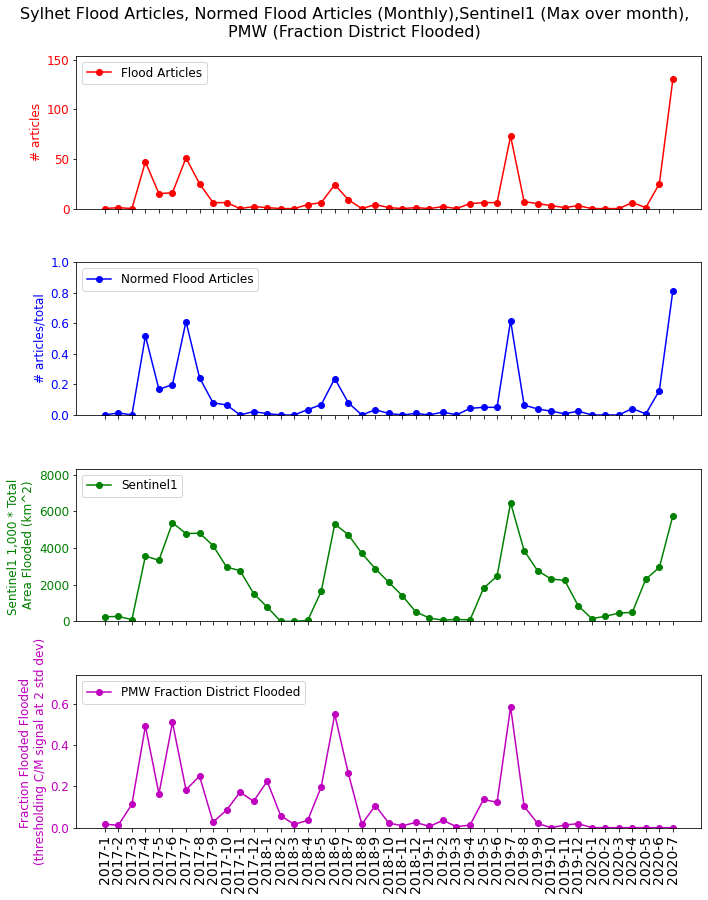

In [132]:
ignoreDates = {2020:[8,9,10,11,12]}
aggDayPrev = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates=ignoreDates)
aggDay = complete_day([(k,v) for k,v in articleDatesSylhet.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='month', ignoreDates=ignoreDates)
aggSentinel = get_Sentinel1_data_monthly('sylhet', ignoreDates=ignoreDates)
aggPMW = get_PMW_data_monthly('sylhet', ignoreDates=ignoreDates)

subPlotN(
            [{'count_list': aggDayPrev, 'label':'Flood Articles',
             'color': 'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed Flood Articles', 
             'color': 'b', 'ylabel': '# articles/total'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color': 'g', 'ylabel': 'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'm', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal at 2 std dev)'}],
            'Sylhet Flood Articles, Normed Flood Articles (Monthly),Sentinel1 (Max over month),\nPMW (Fraction District Flooded)', 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

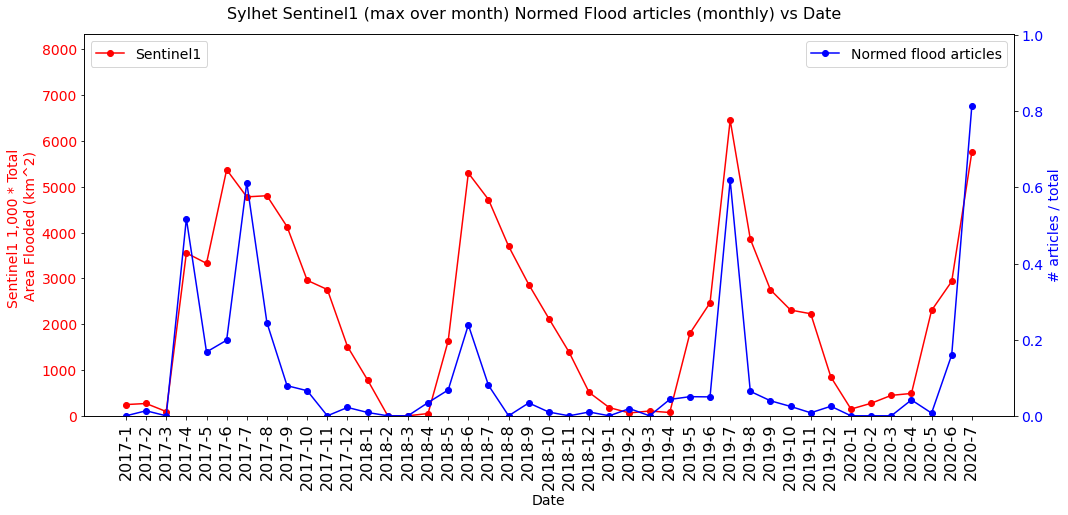

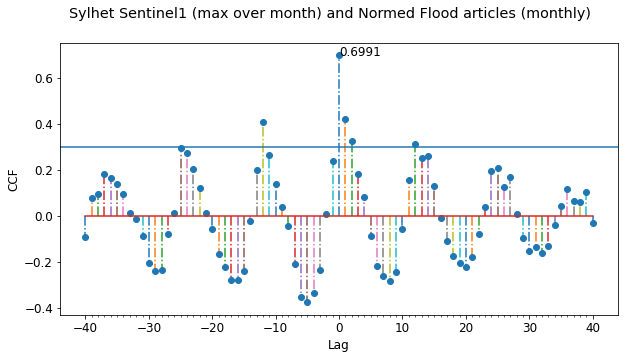

In [133]:
plot_2timeseries(
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'r', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Sylhet Sentinel1 (max over month) Normed Flood articles (monthly) vs Date', 'Date', True)
ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Sylhet Sentinel1 (max over month) and Normed Flood articles (monthly)', lag_max=40)


#### Rajshahi, norm=monthly

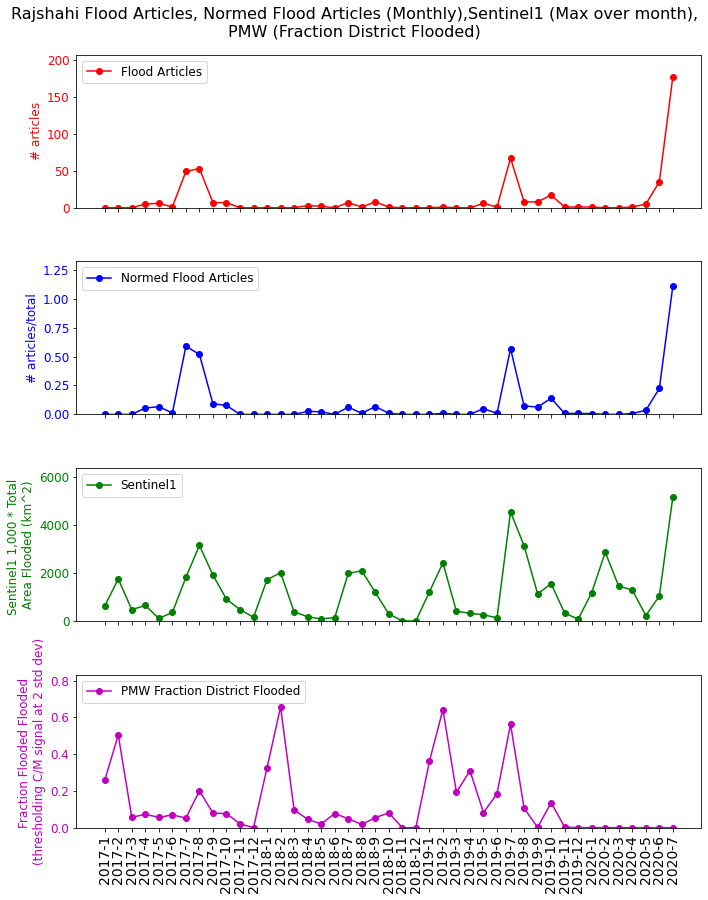

In [134]:
ignoreDates = {2020:[8,9,10,11,12]}
aggDayPrev = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates=ignoreDates)
aggDay = complete_day([(k,v) for k,v in articleDatesRajshahi.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='month', ignoreDates=ignoreDates)
aggSentinel = get_Sentinel1_data_monthly('rajshahi', ignoreDates=ignoreDates)
aggPMW = get_PMW_data_monthly('rajshahi', ignoreDates=ignoreDates)

subPlotN(
            [{'count_list': aggDayPrev, 'label':'Flood Articles',
             'color': 'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed Flood Articles', 
             'color': 'b', 'ylabel': '# articles/total'},
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color': 'g', 'ylabel': 'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggPMW, 'label':'PMW Fraction District Flooded', 
             'color': 'm', 'ylabel': 'Fraction Flooded Flooded \n(thresholding C/M signal at 2 std dev)'}],
            'Rajshahi Flood Articles, Normed Flood Articles (Monthly),Sentinel1 (Max over month),\nPMW (Fraction District Flooded)', 'Year-Month', True)


<Figure size 1080x504 with 0 Axes>

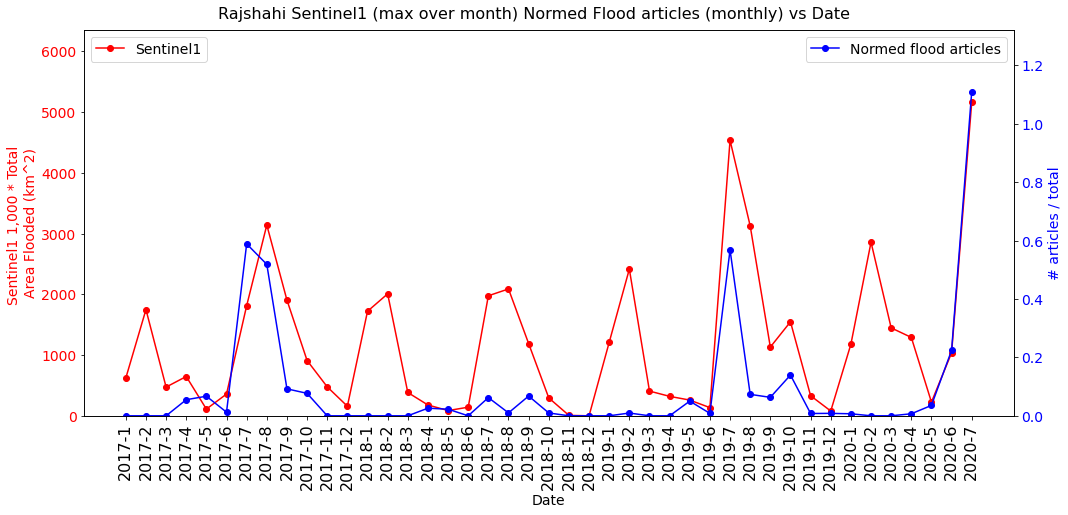

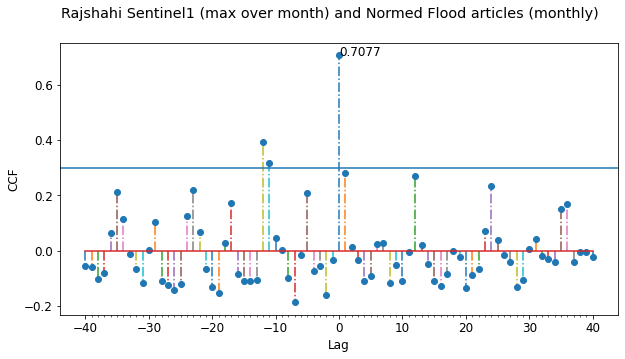

In [135]:
plot_2timeseries(
            {'count_list': aggSentinel, 'label':'Sentinel1', 
             'color':'r', 'ylabel':'Sentinel1 1,000 * Total \nArea Flooded (km^2)'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Rajshahi Sentinel1 (max over month) Normed Flood articles (monthly) vs Date', 'Date', True)

ccf(aggSentinel, aggDay, tupList=True, plot=True,
    title='Rajshahi Sentinel1 (max over month) and Normed Flood articles (monthly)', lag_max=40)

#### Monthly, norm='yearly'

<Figure size 1080x504 with 0 Axes>

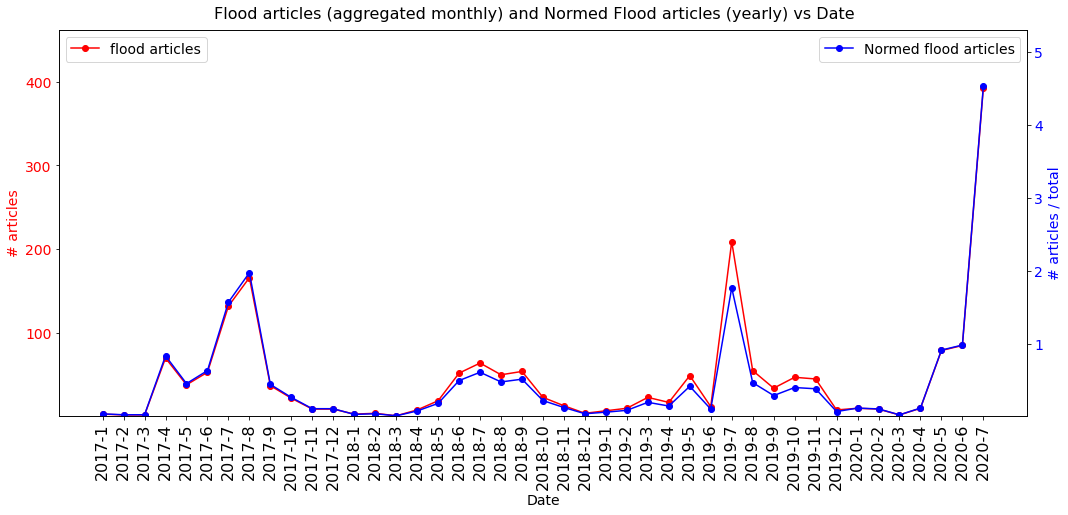

In [136]:
ignoreDates = {2020:[8,9,10,11,12]}
aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', ignoreDates=ignoreDates)
aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
                      aggType='month', normDict=dateCounts, normAgg='year', ignoreDates=ignoreDates)

plot_2timeseries(
            {'count_list': aggDayPrev, 'label':'flood articles', 
             'color':'r', 'ylabel':'# articles'},
            {'count_list': aggDay, 'label':'Normed flood articles', 
             'color': 'b', 'ylabel': '# articles / total'},
            'Flood articles (aggregated monthly) and Normed Flood articles (yearly) vs Date', 'Date', True)


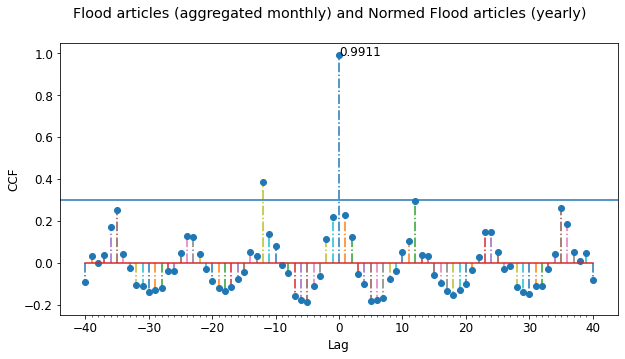

In [137]:
ccf(aggDayPrev, aggDay, tupList=True, plot=True,
    title='Flood articles (aggregated monthly) and Normed Flood articles (yearly)', lag_max=40)

#### Weekly, norm='monthly'

In [140]:
# aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
#                       aggType='week')
# aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
#                       aggType='week', normDict=dateCounts, normAgg='month')

# plot_2timeseries(
#             {'count_list': aggDayPrev, 'label':'flood articles', 
#              'color':'r', 'ylabel':'# articles'},
#             {'count_list': aggDay, 'label':'Normed flood articles', 
#              'color': 'b', 'ylabel': '# articles / total'},
#             'Flood articles (aggregated weekly) and Normed Flood articles (monthly) vs Date', 'Date', True, skip=10)


In [141]:
# ccf(aggDayPrev, aggDay, tupList=True, plot=True,
#     title='Flood articles (aggregated weekly) and Normed Flood articles (monthly)', lag_max=150)

#### weekly, norm='yearly'

In [142]:
# aggDayPrev = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
#                       aggType='week')
# aggDay = complete_day([(k,v) for k,v in articleDates.items()], year_range=[2017,2020], 
#                       aggType='week', normDict=dateCounts, normAgg='year')

# plot_2timeseries(
#             {'count_list': aggDayPrev, 'label':'flood articles', 
#              'color':'r', 'ylabel':'# articles'},
#             {'count_list': aggDay, 'label':'Normed flood articles', 
#              'color': 'b', 'ylabel': '# articles / total'},
#             'Flood articles (aggregated weekly) and Normed Flood articles (yearly) vs Date', 'Date', True, skip=10)


In [143]:
# ccf(aggDayPrev, aggDay, tupList=True, plot=True,
#     title='Flood articles (aggregated weekly) and Normed Flood articles (yearly)', lag_max=150)